In [2]:
# !pip install lightning

# Image Super Resolution + Denoising

The main goal of this project is to tackle a problem of jointly denoising (only Gaussian noise is considered) and upsampling an image (super resolution).

Some code is already provided. You can modify most of the code unless specifically stated that some section should not be changed.

In [36]:
from matplotlib import pyplot as plt
import numpy as np
import math
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import cv2
import shutil
from tqdm import tqdm
import random

import torchmetrics

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch import Trainer, LightningModule

RANDOM_SEED = 42

random.seed(RANDOM_SEED) # DO NOT CHANGE THIS
pl.seed_everything(RANDOM_SEED)

# add more imports here

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

## Loading the data

Let's start by loading the data. You can find the dataset [here](https://drive.google.com/file/d/1IQ-lQc14q3ROaaTJCMKIIH8dhaSM1B6a/view?usp=share_link).

Download the zip file and upload it to your google drive.

Let's now mount the drive and access the folder where you saved the dataset.


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [37]:
# access the data
datadir = '/content/drive/MyDrive/Colab Notebooks/Image-Super-Resolution-Denoising/dataset.zip' # change this path to where you stored the dataset

# unzip images
shutil.unpack_archive(datadir)

In [38]:
# DO NOT CHANGE THIS CELL
images_list = os.listdir('dataset/ground_truth')
random.shuffle(images_list)

train_list = images_list[:800]
val_list = images_list[800:900]
test_list = images_list[900:]
print(len(train_list), len(val_list), len(test_list))

800 100 100


## Visualizing the data

In the following section, you can use the function ``` display_image_grid ``` to visualize the data.

In [39]:
# note that you can use this function to visualize your model's predictions
def display_image_grid(images_filenames, images_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10,24))
    for i, image_filename in enumerate(images_filenames):
        gt = cv2.imread(os.path.join(images_directory, 'ground_truth', image_filename))

        input = np.load(os.path.join(images_directory, 'low_res_noisy_images', image_filename.replace('.jpg', '.npy')))
        print(input.shape, gt.shape)

        # plot
        ax[i, 0].imshow(input)
        ax[i, 1].imshow(gt)

        ax[i, 0].set_title("Input")
        ax[i, 1].set_title("Ground-truth")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

In [ ]:
# display_image_grid(train_list[:10], 'dataset')

## Building the Dataset

In [40]:
class CustomDataset(Dataset):
    def __init__(self, img, paths, transform_img=None, transform_label=None, transform_colorspace=False): # add other params as needed
        self.transform_colorspace = transform_colorspace
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.img = img
        self.paths = paths

    def __len__(self):
        return len(self.img) # return the number of images in the dataset

    def __getitem__(self, idx):
        img_ = self.img[idx]
        path_labels = os.path.join(self.paths, 'ground_truth', img_)
        path_img = os.path.join(self.paths, 'low_res_noisy_images', img_.replace('.jpg', '.npy'))

        image = np.load(path_img)
        # image = cv2.resize(image, (320, 240), interpolation=cv2.INTER_CUBIC)
        label = cv2.imread(path_labels)

        if self.transform_colorspace:
          image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
          label = cv2.cvtColor(label, cv2.COLOR_RGB2YCrCb)

        if self.transform_img and self.transform_label:
          image = self.transform_img(image)
          label = self.transform_label(label)
          image = image[0, :, :].unsqueeze(0)
          label = label[0, :, :].unsqueeze(0)

        return  image, label

In [41]:
transform_img = v2.Compose([
    v2.ToImage(), # Convert to tensor
    v2.ToDtype(torch.uint8, scale=False),
    v2.Resize(size=(240, 320), antialias=True, interpolation = v2.InterpolationMode.BICUBIC),
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
])

transform_label = v2.Compose([
    v2.ToImage(),  # Convert to tensor
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
])

## Defining the hyperparameters and model

Some hyperparameters have already been defined. Feel free to experiment and change them as you see fit.

In [42]:
# hyperparameters
batch_size = 32
num_workers = 8

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [43]:
# build the dataset and dataloaders
# DO NOT CHANGE THIS CELL (particularly the shuffling)
train_dataset = CustomDataset(train_list, '/content/dataset/', transform_img, transform_label, transform_colorspace = True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = CustomDataset(val_list, '/content/dataset/', transform_img, transform_label, transform_colorspace = True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

test_dataset = CustomDataset(test_list, '/content/dataset/', transform_img, transform_label, transform_colorspace = True)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

In [44]:
for idx, (image, label) in enumerate(train_dataloader):
  print(label.shape)
  print(image.shape)
  print()
  if idx == 2:
    break

torch.Size([32, 1, 240, 320])
torch.Size([32, 1, 240, 320])

torch.Size([32, 1, 240, 320])
torch.Size([32, 1, 240, 320])

torch.Size([32, 1, 240, 320])
torch.Size([32, 1, 240, 320])



## Exercise 1

VDSR takes as input an already upsampled version of the low resolution image. This upsampled image can be obtained using bicubic interpolation. How well does this interpolation method perform on the given dataset?

Evaluate its performance in terms of PSNR on the **test** set.

In [45]:
### Write your code here ###

from skimage.metrics import peak_signal_noise_ratio as psnr

PSNR_values = []

for idx, (image, label) in enumerate(test_dataset):
    psnr_value = psnr(image.cpu().numpy(), label.cpu().numpy(), data_range = 1)
    PSNR_values.append(psnr_value)

# Compute the average PSNR over the test set
average_psnr = np.mean(PSNR_values)
print(f'Average PSNR for Bicubic Interpolation on Test Set: {average_psnr:.2f} dB')


Average PSNR for Bicubic Interpolation on Test Set: 21.00 dB


Image:  (240, 320, 1)
Label:  (240, 320, 1)
 
Image:  (240, 320, 1)
Label:  (240, 320, 1)
 


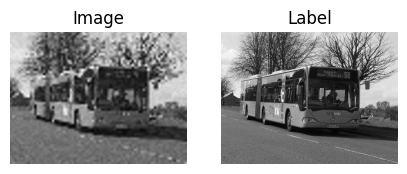

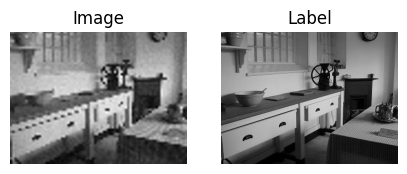

In [46]:
for idx, (image, label) in enumerate(test_dataset):
    image = np.transpose(image.numpy(), (1, 2, 0))
    label = np.transpose(label.numpy(), (1, 2, 0))
    print('Image: ', image.shape)
    print('Label: ', label.shape)
    print(' ')
    plt.figure(figsize=(5, 3))
    ax1 = plt.subplot(1, 2, 1)
    # ax1.imshow(np.clip(image, 0, 1), cmap = 'gray')
    ax1.imshow(image, cmap = 'gray')
    ax1.set_title("Image")
    ax1.axis('off')
    ax2 = plt.subplot(1, 2, 2)
    # ax2.imshow( np.clip(label, 0, 1)  , cmap = 'gray')
    ax2.imshow(label, cmap = 'gray')
    ax2.set_title("Label")
    ax2.axis('off')
    if idx == 1:
      break

## Defining the VDSR model

In [47]:
class ConvReLU(nn.Module):
    def __init__(self, channels: int) -> None:
        super(ConvReLU, self).__init__()
        self.conv = nn.Conv2d(channels, channels, (3, 3), (1, 1), (1, 1), bias=False)
        self.relu = nn.ReLU(True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.conv(x)
        out = self.relu(out)

        return out


class VDSR(nn.Module):
    def __init__(self) -> None:
        super(VDSR, self).__init__()
        # Input layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, (3, 3), (1, 1), (1, 1), bias=False),
            nn.ReLU(True),
        )

        # Features trunk blocks
        trunk = []
        for _ in range(18):
            trunk.append(ConvReLU(64))
        self.trunk = nn.Sequential(*trunk)

        # Output layer
        self.conv2 = nn.Conv2d(64, 1, (3, 3), (1, 1), (1, 1), bias=False)

        # Initialize model weights
        self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._forward_impl(x)

    # Support torch.script function
    def _forward_impl(self, x: torch.Tensor) -> torch.Tensor:
        identity = x

        out = self.conv1(x)
        out = self.trunk(out)
        out = self.conv2(out)

        out = torch.add(out, identity)

        return out

    def _initialize_weights(self) -> None:
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                module.weight.data.normal_(0.0, math.sqrt(2 / (module.kernel_size[0] * module.kernel_size[1] * module.out_channels)))

## Exercise 2

Train the VDSR model in the dataset (use the training and validation sets).

Evaluate its performance in terms of PSNR on the **test** set.

In [48]:
class LightningModel(pl.LightningModule):
    def __init__(self, model, optimizer_name, optimizer_hparams):
        """LightningModel.
        Args:
            model: Name of the model/CNN to run. Used for creating the model
            optimizer_name: Name of the optimizer to use. Currently supported: Adam, SGD
            optimizer_hparams: Hyperparameters for the optimizer, as dictionary. This includes learning rate, weight decay, etc.
         """
        super().__init__()

        self.model = model
        self.save_hyperparameters(ignore=['model'])
        self.loss_module = torch.nn.MSELoss(reduction = 'mean')

        # Set up attributes for computing the accuracy
        self.train_psnr = torchmetrics.image.PeakSignalNoiseRatio()
        self.train_ssim = torchmetrics.image.StructuralSimilarityIndexMeasure()

        self.valid_psnr = torchmetrics.image.PeakSignalNoiseRatio()
        self.valid_ssim = torchmetrics.image.StructuralSimilarityIndexMeasure()

        self.test_psnr = torchmetrics.image.PeakSignalNoiseRatio()
        self.test_ssim = torchmetrics.image.StructuralSimilarityIndexMeasure()


    def forward(self, x):
        return self.model(x)

    # A common forward step to compute the loss and label
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        image, label = batch
        predicted_label = self(image)

        loss = self.loss_module(predicted_label, label)

        return loss, label, predicted_label

    def training_step(self, batch, batch_idx):
        loss, label, predicted_label = self._shared_step(batch)
        self.train_psnr.update(predicted_label, label)
        self.train_ssim.update(predicted_label, label)
        metrics = {'train_loss': loss, 'train_psnr': self.train_psnr, 'train_ssim': self.train_ssim}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, label, predicted_label = self._shared_step(batch)
        self.valid_psnr.update(predicted_label, label)
        self.valid_ssim.update(predicted_label, label)
        metrics = {'valid_loss': loss, 'valid_psnr': self.valid_psnr, 'valid_ssim': self.valid_ssim}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, label, predicted_label = self._shared_step(batch)
        self.test_psnr.update(predicted_label, label)
        self.test_ssim.update(predicted_label, label)
        metrics = {'test_loss': loss, 'test_psnr': self.test_psnr, 'test_ssim': self.test_ssim}
        self.log_dict(metrics, on_epoch=True, on_step=False, prog_bar=True)

    def configure_optimizers(self):
      # We will support AdamW or SGD as optimizers.
      if self.hparams.optimizer_name == "AdamW":
          optimizer = torch.optim.AdamW(self.parameters(), **self.hparams.optimizer_hparams)
      elif self.hparams.optimizer_name == "SGD":
          optimizer = torch.optim.SGD(self.parameters(), **self.hparams.optimizer_hparams)
      else:
          assert False, f'Unknown optimizer: "{self.hparams.optimizer_name}"'

      # scheduler = torch.optim.swa_utils.SWALR(optimizer, anneal_strategy="cos", anneal_epochs=5, swa_lr=0.002)
      # scheduler = {'scheduler': torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95), 'name': 'expo_lr'}
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
      return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}


In [49]:
pl.seed_everything(RANDOM_SEED)

model = VDSR()
model.to(device)

learning_rate = 0.0001

optimizer_name = "AdamW"
optimizer_hparams = {"lr": learning_rate, "betas": (0.9, 0.99), "eps": 1e-08, "weight_decay": 0.0001, "amsgrad": False}

# optimizer_name = "SGD"
# optimizer_hparams = {'lr': 0.01, 'momentum': 0.9, 'dampening': 0, 'weight_decay':  0.0001, 'nesterov': False}

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

arch = 'VDSR'

cbs = pl.callbacks.ModelCheckpoint(dirpath = f'/content/drive/MyDrive/Colab Notebooks/Image-Super-Resolution-Denoising/results/checkpoints_{arch}',
                                   filename = arch,
                                   verbose = True,
                                   monitor = 'valid_loss',
                                   mode = 'min')

logger_csv = CSVLogger(save_dir="/content/drive/MyDrive/Colab Notebooks/Image-Super-Resolution-Denoising/results/logs/", name="my-model")

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


In [50]:
pl.seed_everything(RANDOM_SEED)

PERCENT_VALID_EXAMPLES = 1
EPOCHS = 30
LOG_EVERY_N_STEPS = 1

trainer = pl.Trainer(
    limit_val_batches = PERCENT_VALID_EXAMPLES,
    max_epochs = EPOCHS,
    logger=logger_csv,
    callbacks = cbs,
    log_every_n_steps=LOG_EVERY_N_STEPS,
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable

)


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: `Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.


## Training the model.
---

In [19]:
# trainer.fit(model_light, train_dataloaders = train_dataloader, val_dataloaders=val_dataloader)

#### Load the model from the checkpoint
---

In [51]:
# If you are working in GPU, please, you do not run: device = torch.device('cpu')
device = torch.device('cpu')
checkpoint_file = '/content/drive/MyDrive/Colab Notebooks/Image-Super-Resolution-Denoising/results/checkpoints_VDSR/VDSR.ckpt'

pl.seed_everything(RANDOM_SEED)

model_light = LightningModel(model, optimizer_name, optimizer_hparams)

checkpoint = torch.load(checkpoint_file, map_location=device)
model_light.load_state_dict(checkpoint['state_dict'])

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


<All keys matched successfully>

## Teste dataset
---

In [52]:
# run test dataset
test_metrics = trainer.test(model_light, dataloaders=test_dataloader, verbose=False)
print(test_metrics)

Testing: |          | 0/? [00:00<?, ?it/s]

[{'test_loss': 0.008559292182326317, 'test_psnr': 20.675621032714844, 'test_ssim': 0.5899768471717834}]


## Graph of results
---

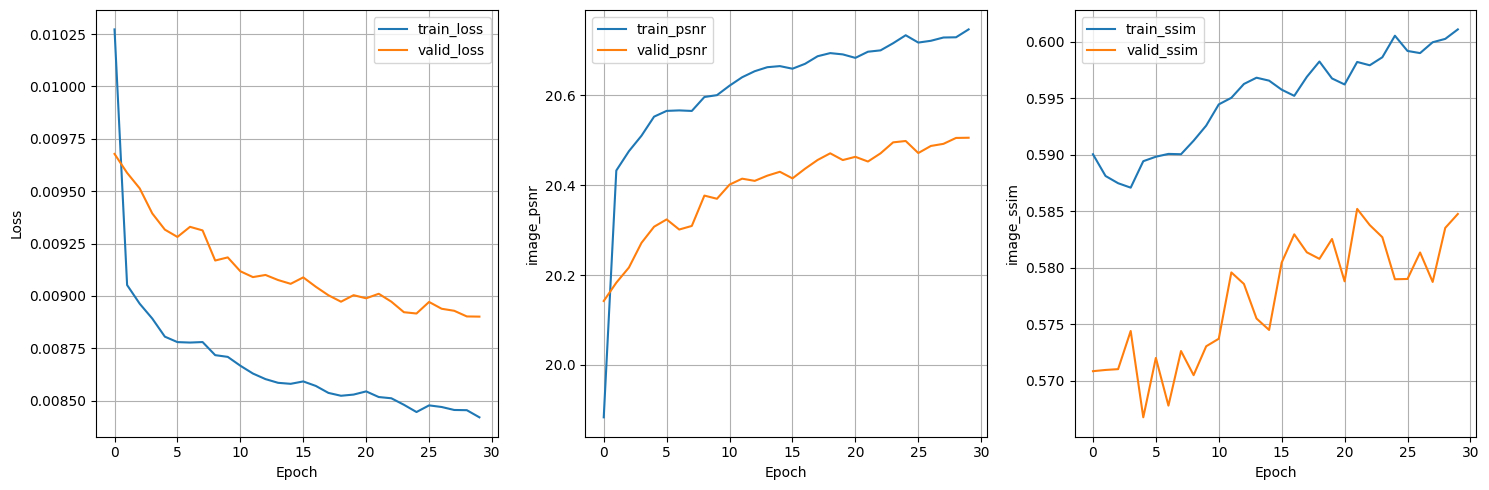

In [53]:
import pandas as pd

def printdf(df):
  return display(pd.DataFrame(df))

path = '/content/drive/MyDrive/Colab Notebooks/Image-Super-Resolution-Denoising/results/logs/my-model/version_0'
metrics = pd.read_csv(f"{path}/metrics.csv")
metrics

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
# df_metrics

fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust figsize as needed
df_metrics[["train_loss", "valid_loss"]].plot(ax=axes[0], grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_psnr", "valid_psnr"]].plot(ax=axes[1], grid=True, legend=True, xlabel='Epoch', ylabel='image_psnr')
df_metrics[["train_ssim", "valid_ssim"]].plot(ax=axes[2], grid=True, legend=True, xlabel='Epoch', ylabel='image_ssim')

plt.tight_layout()  # Adjust subplot parameters to give specified padding.
plt.show()

In [54]:
class CustomDataset_(Dataset):
    def __init__(self, img, paths, transform_img=None, transform_label=None, transform_colorspace=False): # add other params as needed
        self.transform_colorspace = transform_colorspace
        self.transform_img = transform_img
        self.transform_label = transform_label
        self.img = img
        self.paths = paths

    def __len__(self):
        return len(self.img) # return the number of images in the dataset

    def __getitem__(self, idx):
        img_ = self.img[idx]
        path_labels = os.path.join(self.paths, 'ground_truth', img_)
        path_img = os.path.join(self.paths, 'low_res_noisy_images', img_.replace('.jpg', '.npy'))

        image = np.load(path_img)
        label = cv2.imread(path_labels)

        if self.transform_colorspace:
          image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
          label = cv2.cvtColor(label, cv2.COLOR_RGB2YCrCb)

        # if self.transform_img and self.transform_label:
          image = self.transform_img(image)
          label = self.transform_label(label)

        return image, label


test_dataset_ = CustomDataset_(test_list, '/content/dataset/', transform_img, transform_label, transform_colorspace = True)
test_dataloader_ = DataLoader(test_dataset_, batch_size=1, num_workers=num_workers, shuffle=False)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


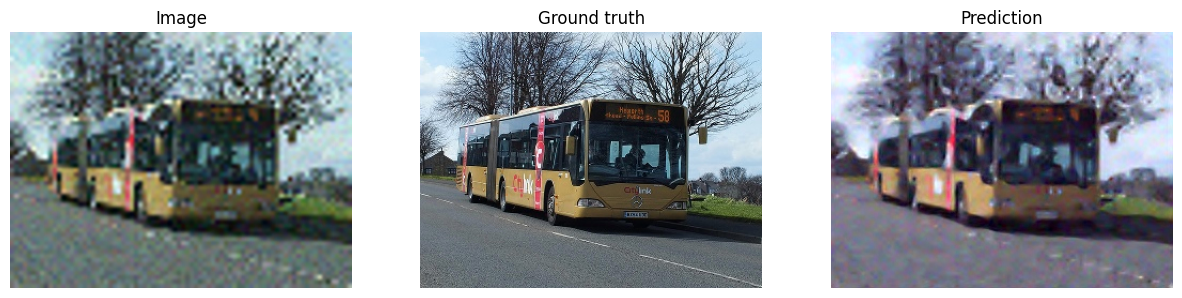

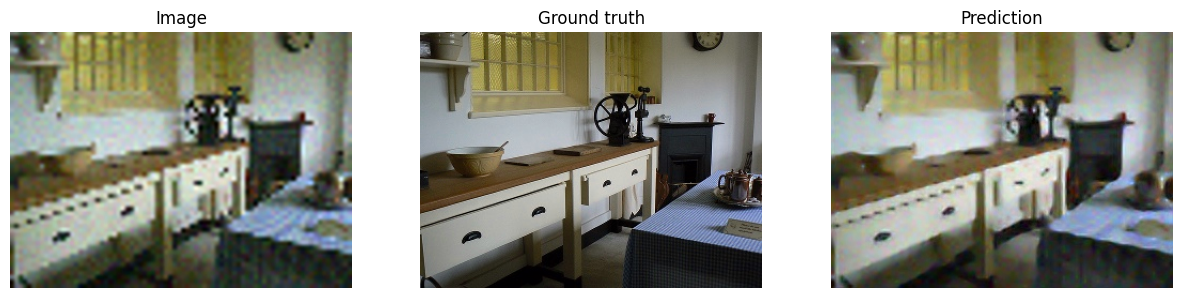

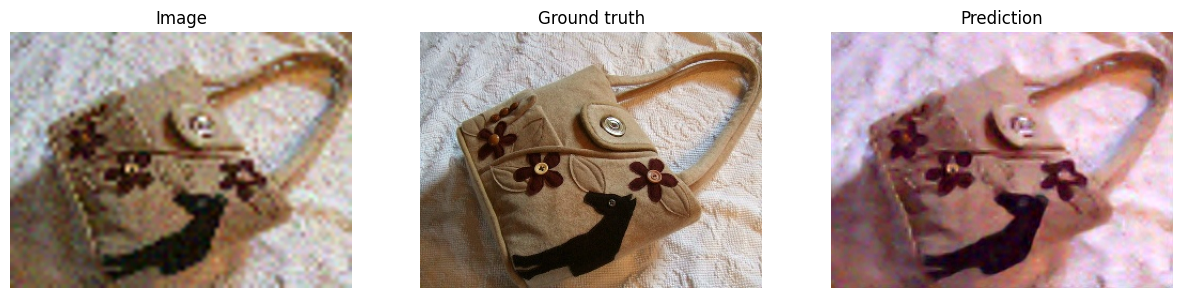

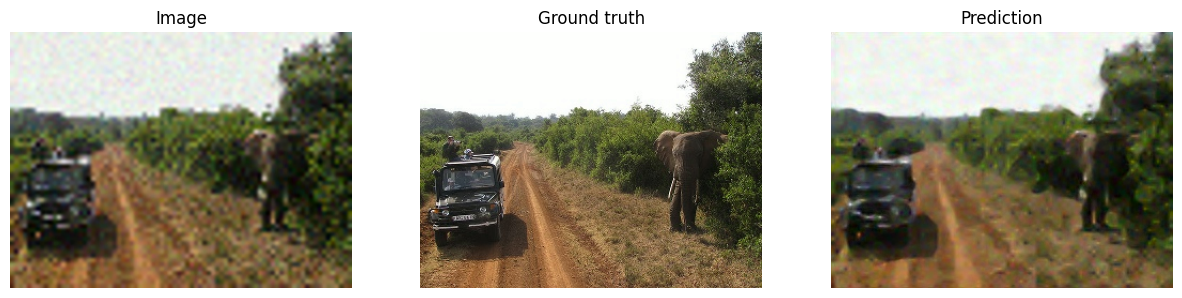

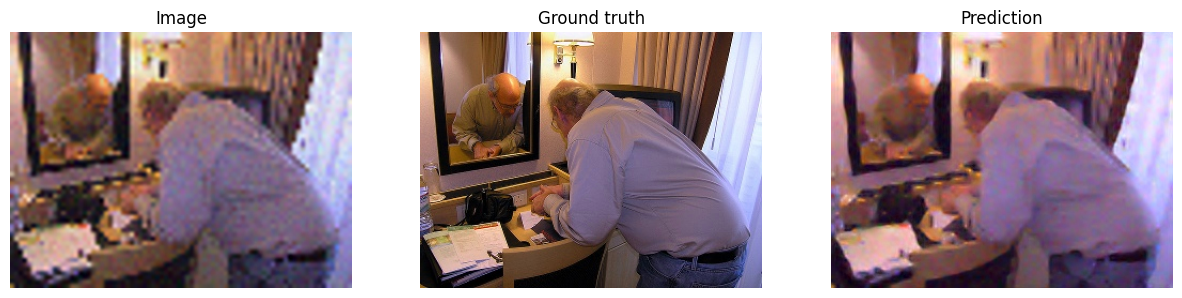

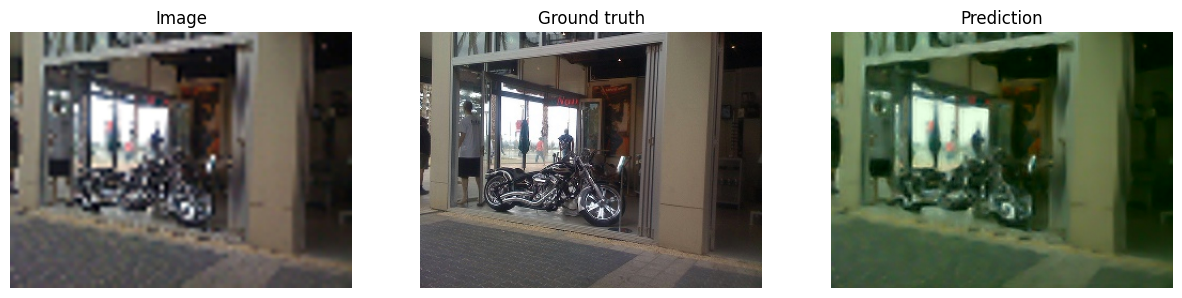

In [56]:
pl.seed_everything(RANDOM_SEED)

def normalize(image):
    scaled_image = (image - np.min(image)) / (np.max(image) -  np.min(image))
    scaled_image *= 255
    return scaled_image.astype(np.uint8)

with torch.no_grad():
    model.eval()
    for idx, batch in enumerate(test_dataloader_):
        images, targets = batch
        x_lumm = images[:, 0, :, :].unsqueeze(1)
        x_cb  = images[:, 1, :, :].unsqueeze(1)
        x_cr  = images[:, 2, :, :].unsqueeze(1)

        x_lum = model_light(x_lumm)

        # pred_target = torch.cat((targets[:, 0, :, :].unsqueeze(1), x_cb, x_cr), dim=1)
        pred_target = torch.cat((x_lum, x_cb, x_cr), dim=1)

        images = normalize(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
        targets = normalize(np.transpose(targets[0].cpu().numpy(), (1, 2, 0)))
        pred_target = normalize(np.transpose(pred_target[0].cpu().numpy(), (1, 2, 0)))

        images = cv2.cvtColor(images, cv2.COLOR_YCrCb2RGB)
        targets = cv2.cvtColor(targets, cv2.COLOR_YCrCb2RGB)
        pred_target = cv2.cvtColor(pred_target, cv2.COLOR_YCrCb2RGB)

        plt.figure(figsize=(15, 10))

        plt.subplot(1, 3, 1)
        plt.imshow(images)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(targets)
        plt.title("Ground truth")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_target)
        plt.title("Prediction")
        plt.axis("off")

        plt.show()
        if idx == 5:
          break

---
The model still requires more attention in the process of finding the best parameters, that is, in optimization.

Although the photos have shown some improvement, this improvement is still not ideal as can be seen above.

During the training process, various configurations for AdamW and SGD were tested. But this one presented was the best among all that I found.

---